<a href="https://colab.research.google.com/github/peksikeksi/mechanical-parts-classification-resnet18/blob/master/mechanical_parts_classification_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries include TensorFlow for building the model, numpy for numerical computations,
# matplotlib for plotting, sklearn for metrics computation, cv2 for image processing,
# and other utilities for data manipulation and model evaluation.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from datetime import datetime
import pathlib
import io
import os
import time
import random
import shutil
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Layer, GlobalAveragePooling2D, AveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense, Flatten,
                                     InputLayer, BatchNormalization, Input, RandomContrast, GaussianNoise, RandomContrast, Rescaling, Resizing, Reshape, RandomBrightness)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_probability as tfp

### Configuration parameters

In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
LEARNING_RATE = 1e-2
NUM_EPOCHS = 20
NUM_FILTERS = 6
KERNEL_SIZE = 3
STRIDES = 1
POOL_SIZE = 2
DENSE_UNITS_1 = 1024
DENSE_UNITS_2 = 128
NUM_CLASSES = 4
CLASS_NAMES = ['bolt', 'locatingpin', 'nut', 'washer']
TRAIN_DIRECTORY = "/content/dataset/training_set"
VAL_DIRECTORY = "/content/dataset/validation_set"

## Data Management

In [3]:
# Install Kaggle API
!pip install -q kaggle

# Set up Kaggle credentials
!mkdir -p ~/.kaggle  # Create the hidden directory if it doesn't exist
!cp kaggle.json ~/.kaggle/  # Copy kaggle.json to the hidden directory
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for your user only

# Download and unzip the dataset
try:
    # Check if the dataset file exists before downloading
    if not os.path.exists('/content/images-of-mechanical-parts-boltnut-washerpin.zip'):
        !kaggle datasets download -d manikantanrnair/images-of-mechanical-parts-boltnut-washerpin

    # Check if the dataset directory exists before unzipping
    if not os.path.exists('/content/dataset'):
        !mkdir /content/dataset

    !unzip -q '/content/images-of-mechanical-parts-boltnut-washerpin.zip' -d '/content/dataset/'

    print("Dataset downloaded and unzipped successfully.")
except Exception as e:
    print("Error:", e)

Dataset URL: https://www.kaggle.com/datasets/manikantanrnair/images-of-mechanical-parts-boltnut-washerpin
License(s): DbCL-1.0
 68% 33.0M/48.2M [00:00<00:00, 75.7MB/s]
100% 48.2M/48.2M [00:00<00:00, 86.8MB/s]
Dataset downloaded and unzipped successfully.


In [4]:
# Define paths to your dataset folders
dataset_path = "/content/dataset/blnw-images-224"
train_path = "/content/dataset/training_set"
validation_path = "/content/dataset/validation_set"

# Create train and validation directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)

# Define the ratio of data to be used for training
train_ratio = 0.8

# Iterate through each category folder
for category_folder in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category_folder)
    train_category_path = os.path.join(train_path, category_folder)
    validation_category_path = os.path.join(validation_path, category_folder)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(validation_category_path, exist_ok=True)

    # Get list of image files in the current category
    image_files = os.listdir(category_path)
    # Shuffle the list of image files
    random.shuffle(image_files)

    # Split the image files into train and validation sets based on the defined ratio
    num_train = int(len(image_files) * train_ratio)
    train_images = image_files[:num_train]
    validation_images = image_files[num_train:]

    # Move images to train directory
    for image_file in train_images:
        src = os.path.join(category_path, image_file)
        dst = os.path.join(train_category_path, image_file)
        shutil.move(src, dst)

    # Move images to validation directory
    for image_file in validation_images:
        src = os.path.join(category_path, image_file)
        dst = os.path.join(validation_category_path, image_file)
        shutil.move(src, dst)

print("Dataset splitting complete.")

Dataset splitting complete.


In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAIN_DIRECTORY,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES,
                                                            color_mode='rgb',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                            shuffle=True,
                                                            seed=42)

Found 6092 files belonging to 4 classes.


In [6]:
val_dataset = tf.keras.utils.image_dataset_from_directory(VAL_DIRECTORY,
                                                          labels='inferred',
                                                          label_mode='categorical',
                                                          class_names=CLASS_NAMES,
                                                          color_mode='rgb',
                                                          batch_size=BATCH_SIZE,
                                                          image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                          shuffle=True,
                                                          seed=42)

Found 1524 files belonging to 4 classes.


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

### Data Visualization

In [ ]:
for image, label in train_dataset.take(1):
    print(image)

tf.Tensor(
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 2

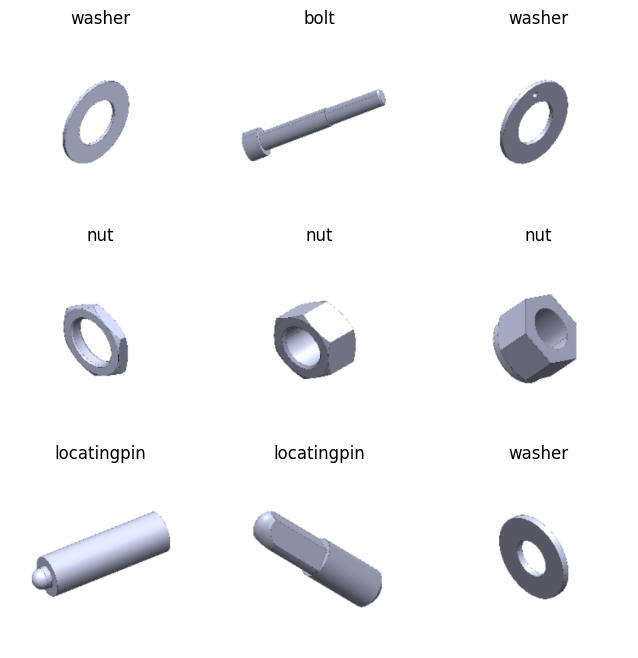

In [ ]:
plt.figure(figsize=(8, 8))

for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i]/255.)  # Normalize pixel values of the images
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis('off')

### Data Augmentation

In [7]:
augmentations = tf.keras.Sequential([RandomBrightness(factor=0.2),
                                     GaussianNoise(stddev=0.1),
                                     RandomContrast(factor=(0., 0.5))])

def augment_image(image, label):
    """Applies data augmentation to the input image.

    Args:
        image (tf.Tensor): The input image to augment.
        label (tf.Tensor): The corresponding label for the image.

    Returns:
        tf.Tensor: The augmented image.
        tf.Tensor: The original label.
    """
    return augmentations(image, training=True), label

In [8]:
def generate_random_bbox(delta):
    """Generate random bounding box coordinates based on the given delta.

    This function generates random bounding box coordinates for cutmix augmentation
    based on the provided delta value.

    Args:
        delta (tf.Tensor): The delta value used for generating the bounding box.

    Returns:
        tuple: A tuple containing the coordinates (ry, rx, rh, rw) of the bounding box.
    """
    rx = tf.cast(tfp.distributions.Uniform(0, IMAGE_SIZE).sample(1)[0], dtype=tf.int32)
    ry = tf.cast(tfp.distributions.Uniform(0, IMAGE_SIZE).sample(1)[0], dtype=tf.int32)

    rw = tf.cast(IMAGE_SIZE*tf.math.sqrt(1-delta), dtype=tf.int32)
    rh = tf.cast(IMAGE_SIZE*tf.math.sqrt(1-delta), dtype=tf.int32)

    rx = tf.clip_by_value(rx - rw//2, 0, IMAGE_SIZE)
    ry = tf.clip_by_value(ry - rh//2, 0, IMAGE_SIZE)

    xbr = tf.clip_by_value(rx + rw//2, 0, IMAGE_SIZE)
    ybr = tf.clip_by_value(ry + rh//2, 0, IMAGE_SIZE)

    rw = xbr - rx
    if(rw == 0):
        rw = 1

    rh = ybr - ry
    if(rh == 0):
        rh = 1

    return ry, rx, rh, rw

In [9]:
def cutmix(image_label_pair1, image_label_pair2):
    """Apply cutmix augmentation to a pair of image-label pairs.

    Args:
        image_label_pair1 (tuple): A tuple containing the first image and its corresponding label.
        image_label_pair2 (tuple): A tuple containing the second image and its corresponding label.

    Returns:
        tuple: A tuple containing the augmented image and its corresponding label.
    """
    (image1, label1), (image2, label2) = image_label_pair1, image_label_pair2

    delta = tfp.distributions.Beta(.2, .2)
    delta = delta.sample(1)[0]

    ry, rx, rh, rw = generate_random_bbox(delta)

    crop1 = tf.image.crop_to_bounding_box(image1, ry, rx, rh, rw)
    pad1 = tf.image.pad_to_bounding_box(crop1, ry, rx, IMAGE_SIZE, IMAGE_SIZE)

    crop2 = tf.image.crop_to_bounding_box(image2, ry, rx, rh, rw)
    pad2 = tf.image.pad_to_bounding_box(crop2, ry, rx, IMAGE_SIZE, IMAGE_SIZE)

    image = image1 - pad1 + pad2

    delta = tf.cast(1-(rw*rh)/(IMAGE_SIZE*IMAGE_SIZE), dtype=tf.float32)
    label = delta*tf.cast(label1, dtype=tf.float32) + (1-delta)*tf.cast(label2, dtype=tf.float32)

    return image, label

In [11]:
# Apply data augmentation to the training dataset
augmented_dataset_1 = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
augmented_dataset_2 = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Combine augmented datasets into a single dataset for cutmix
mixed_dataset = tf.data.Dataset.zip((augmented_dataset_1, augmented_dataset_2))

# Apply cutmix augmentation to the mixed dataset and prefetch batches
training_dataset = (mixed_dataset
                    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

In [ ]:
for image, label in training_dataset.take(1):
    print(image)

tf.Tensor(
[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.      

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

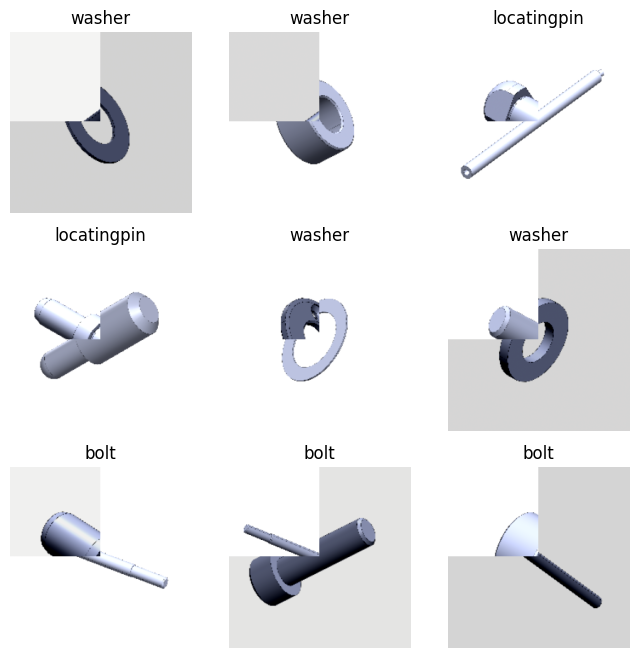

In [ ]:
plt.figure(figsize=(8, 8))

for images, labels in training_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i]/255.)  # Normalize pixel values of the images
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis('off')

## Modeling

In [12]:
class ResConv2D(Layer):
    """Custom convolutional layer with optional batch normalization for ResNet architecture.

    This layer combines a convolutional operation with optional batch normalization and activation.

    Args:
        num_filters (int): Number of filters (output channels) in the convolutional layer.
        kernel_size (tuple or int): Size of the convolutional kernel. If tuple, should specify height and width.
        num_strides (tuple or int, optional): Strides for the convolution operation. Default is (1, 1).
        activation (str or keras.layers.Activation, optional): Activation function applied after convolution.
            Default is 'relu'.
        use_batch_norm (bool, optional): Whether to apply batch normalization. Default is True.
        padding (str, optional): One of 'valid' or 'same'. Padding mode for convolution operation. Default is 'valid'.

    Attributes:
        conv: Conv2D layer.
        use_batch_norm (bool): Whether batch normalization is applied.
        batch_norm: BatchNormalization layer if use_batch_norm is True.
        activation: Activation function applied after convolution.

    Returns:
        keras.Tensor: Output tensor after convolution, batch normalization (if applied), and activation.
    """
    def __init__(self, num_filters, kernel_size, num_strides=(1, 1), activation='relu', use_batch_norm=True, padding='valid'):
        super(ResConv2D, self).__init__(name='res_conv2d')

        self.conv = Conv2D(filters=num_filters,
                           kernel_size=kernel_size,
                           strides=num_strides,
                           padding=padding,
                           use_bias=not use_batch_norm, # Disable bias if batch normalization is used
                           kernel_initializer='glorot_uniform')

        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.batch_norm = BatchNormalization()

        self.activation = Activation(activation)

    def call(self, x, training=True):
        """Call method for the ResConv2D layer.

        Args:
            x (keras.Tensor): Input tensor.
            training (bool): Whether the model is in training mode.

        Returns:
            keras.Tensor: Output tensor after convolution, batch normalization (if applied), and activation.
        """
        x = self.conv(x)
        if self.use_batch_norm:
            x = self.batch_norm(x, training)
        x = self.activation(x)
        return x

In [13]:
class ResidualChain(Layer):
    """Residual chain for ResNet architecture.

    This chain consists of two residual blocks with optional downsampling using strided convolutions.

    Args:
        num_filters (int): Number of filters (output channels) in the convolutional layers.
        num_strides (int, optional): Strides for the first convolutional layer. Default is 1.
        activation (str or keras.layers.Activation, optional): Activation function applied after each convolution.
            Default is 'relu'.

    Returns:
        keras.Tensor: Output tensor after residual chain operations.
    """
    def __init__(self, num_filters, num_strides=1, activation='relu'):

        super(ResidualChain, self).__init__(name='res_chain')

        self.conv1 = ResConv2D(num_filters, kernel_size=3, num_strides=num_strides, padding='same')
        self.conv2 = ResConv2D(num_filters, kernel_size=3, num_strides=1, padding='same')

        self.activation = Activation(activation)

        # Downsampling
        if num_strides != 1:
            self.conv3 = ResConv2D(num_filters, kernel_size=1, num_strides=num_strides)

    def call(self, input_tensor, training=True):
        x = self.conv1(input_tensor, training)
        x = self.conv2(x, training)

        if hasattr(self, 'conv3'):
            x_add = self.conv3(input_tensor, training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, input_tensor])

        return self.activation(x_add)

In [14]:
class ResNet18(Model):
    """Implementation of the ResNet-18 architecture.

    Args:
        num_classes (int): Number of classes for classification.
        **kwargs: Additional keyword arguments passed to the base class.

    Returns:
        keras.Model: ResNet-18 model.

    Raises:
        ValueError: If `num_classes` is not a positive integer.
    """
    def __init__(self, num_classes, **kwargs):
        super(ResNet18, self).__init__(name='resnet_18', **kwargs)
        self.num_classes = num_classes

        # Initial convolutional layer
        self.conv1 = ResConv2D(num_filters=64, kernel_size=7, num_strides=2, padding='same')
        self.max_pool = MaxPooling2D(3,2)

        # Residual blocks
        self.conv2_1 = ResidualChain(num_filters=64)
        self.conv2_2 = ResidualChain(num_filters=64)

        self.conv3_1 = ResidualChain(num_filters=128, num_strides=2)
        self.conv3_2 = ResidualChain(num_filters=128)

        self.conv4_1 = ResidualChain(num_filters=256, num_strides=2)
        self.conv4_2 = ResidualChain(num_filters=256)

        self.conv5_1 = ResidualChain(num_filters=512, num_strides=2)
        self.conv5_2 = ResidualChain(num_filters=512)

        # Global average pooling and fully connected layer
        self.global_pool = GlobalAveragePooling2D()

        self.fc = Dense(units=NUM_CLASSES, activation='softmax')

    def call(self, x, training=True):
        """Forward pass of the ResNet-18 model.

        Args:
            x (tf.Tensor): Input tensor.
            training (bool): Whether the model is in training mode.

        Returns:
            tf.Tensor: Output tensor after passing through the model.
        """
        x = self.conv1(x)
        x = self.max_pool(x)

        x = self.conv2_1(x, training)
        x = self.conv2_2(x, training)

        x = self.conv3_1(x, training)
        x = self.conv3_2(x, training)

        x = self.conv4_1(x, training)
        x = self.conv4_2(x, training)

        x = self.conv5_1(x, training)
        x = self.conv5_2(x, training)

        x = self.global_pool(x)

        return self.fc(x)

## Training

In [15]:
# Define directory for saving checkpoints
checkpoint_dir = 'checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a function to generate a unique checkpoint filename with epoch number
def get_checkpoint_filename(epoch):
    timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    return os.path.join(checkpoint_dir, f'best_weights_{timestamp}_epoch_{epoch}.h5')

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(filepath=get_checkpoint_filename(0),  # Initial filename
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      save_freq='epoch')

# Update the checkpoint filename at the end of each epoch
def update_checkpoint_filename(epoch, logs):
    checkpoint_callback.filepath = get_checkpoint_filename(epoch + 1)  # Update filename for the next epoch

checkpoint_callback.on_epoch_end = update_checkpoint_filename

In [16]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

loss_function = CategoricalCrossentropy(from_logits=False)

metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy'), F1Score(name='f1_score')]

resnet_18 = ResNet18(num_classes=NUM_CLASSES)
resnet_18.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss=loss_function,
                  metrics=metrics)

In [19]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [18]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [21]:
history = resnet_18.fit(training_dataset,
                        validation_data=val_dataset,
                        epochs = NUM_EPOCHS,
                        verbose=1,
                        callbacks=[plateau_callback, checkpoint_callback])

Epoch 1/20
191/191 [==============================] - 95s 408ms/step - loss: 1.4356 - accuracy: 0.4274 - top_k_accuracy: 0.6845 - f1_score: 0.4137 - val_loss: 4.0308 - val_accuracy: 0.3635 - val_top_k_accuracy: 0.5085 - val_f1_score: 0.2359 - lr: 0.0100
Epoch 2/20
191/191 [==============================] - 72s 371ms/step - loss: 0.8865 - accuracy: 0.7065 - top_k_accuracy: 0.8941 - f1_score: 0.6683 - val_loss: 3.4130 - val_accuracy: 0.2507 - val_top_k_accuracy: 0.5000 - val_f1_score: 0.1021 - lr: 0.0100
Epoch 3/20
191/191 [==============================] - 74s 383ms/step - loss: 0.7485 - accuracy: 0.7666 - top_k_accuracy: 0.9289 - f1_score: 0.7208 - val_loss: 20.1436 - val_accuracy: 0.2500 - val_top_k_accuracy: 0.5000 - val_f1_score: 0.1000 - lr: 0.0100
Epoch 4/20
191/191 [==============================] - 72s 372ms/step - loss: 0.6867 - accuracy: 0.7966 - top_k_accuracy: 0.9370 - f1_score: 0.7491 - val_loss: 8.7690 - val_accuracy: 0.2500 - val_top_k_accuracy: 0.5000 - val_f1_score: 0.1

## Evaluation

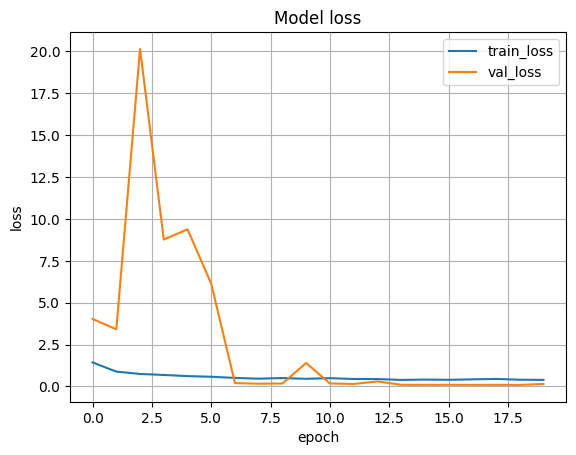

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.grid(True)

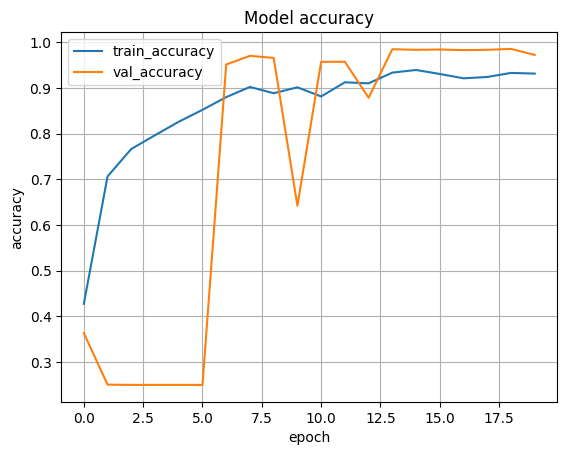

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.grid(True)